# 05: Thunderstorm Wind Average Magnitude Forecast | Region: U.S. South
---

## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [3]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [4]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [5]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [6]:
# Casting the BEGIN_DATE_TIME to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [7]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Thunderstorm Wind in the South (1996-2022)

In [8]:
ts_wind = all_storms[all_storms['event_type'] == 'Thunderstorm Wind']

ts_wind = ts_wind[ts_wind['region'] == 'South']

ts_wind = ts_wind[ts_wind.index > '1996']

In [9]:
ts_wind

,state,region,event_type,magnitude
begin_date_time,,,,
1996-01-02 11:30:00,Florida,South,Thunderstorm Wind,55.0
1996-01-02 12:30:00,Florida,South,Thunderstorm Wind,55.0
1996-01-02 14:00:00,Florida,South,Thunderstorm Wind,55.0
1996-01-02 14:15:00,Florida,South,Thunderstorm Wind,55.0
1996-01-02 18:35:00,South Carolina,South,Thunderstorm Wind,50.0
...,...,...,...,...
2022-03-31 18:16:00,Maryland,South,Thunderstorm Wind,50.0
2022-03-31 18:29:00,Maryland,South,Thunderstorm Wind,50.0
2022-03-31 18:29:00,North Carolina,South,Thunderstorm Wind,50.0


### 3.3. Resampling to Quarterly Averages

In [10]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [11]:
# Resampling to quarterly averages
ts_wind = ts_wind.resample('Q').mean()

# Renaming the column to 'avg_mag'
ts_wind = ts_wind.rename(columns={'magnitude': 'avg_mag'})

In [12]:
# Checking for null values as a result of the resampling

ts_wind.isnull().sum()

avg_mag    0
dtype: int64

In [15]:
ts_wind

,avg_mag
begin_date_time,
1996-03-31,47.838671
1996-06-30,51.359211
1996-09-30,51.992462
1996-12-31,55.419940
1997-03-31,53.040089
...,...
2021-03-31,53.457143
2021-06-30,52.699118
2021-09-30,51.309100


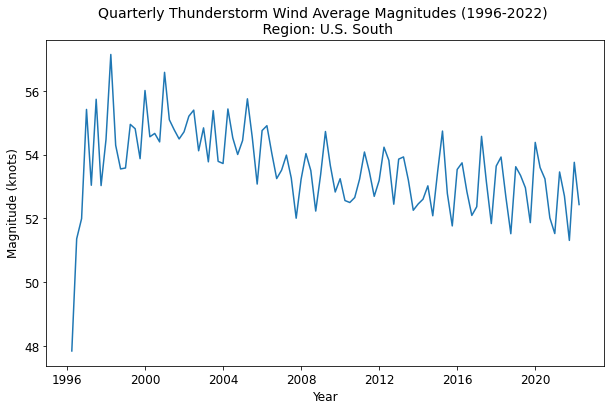

In [16]:
# Quarterly Thunderstorm Wind Average Magnitudes (1996-2022) - Region: U.S. South

plot_series(ts_wind, ['avg_mag'], title='Quarterly Thunderstorm Wind Average Magnitudes (1996-2022) \n Region: U.S. South', xlab='Year', ylab='Magnitude (knots)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

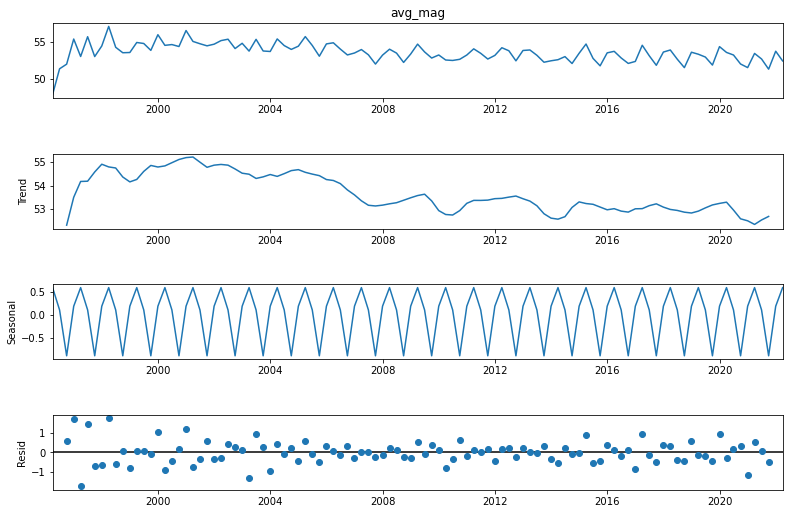

In [17]:
decomp = seasonal_decompose(ts_wind['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see that there is a decrease over time.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model, more so toward the beginning of the 26 year time frame.

### 4.2. Autocorrelation

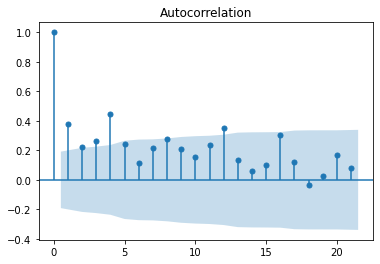

In [18]:
plot_acf(ts_wind['avg_mag']);

For trend, the first 4 lags extend beyond the blue region and indicate the presence of a trend.

For seasonality, the fluctuations do not occur with a fixed and known frequency and therefore, indicates that there is no seasonality in the data.

For lags, it seems that not using the first 4 will be useful to include in the model, as they extend beyond the blue region.

### 4.3. Partial Autocorrelation

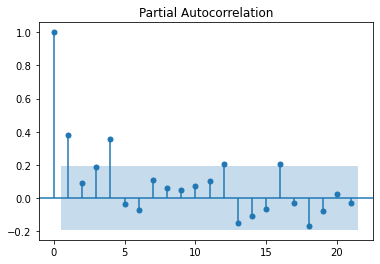

In [20]:
plot_pacf(ts_wind['avg_mag']);

For seasonality, as seen in the autocorrelation, the fluctuations do not occur with a fixed and known frequency and therefore, confirms that there is no seasonality present.

For lags, the number of lags that extend beyond the blue region have been reduced, and not it seems that only the first would be useful to include in the model.

### 4.4. Stationarity

In [21]:
# Dickey-Fuller Stationarity Test

adfuller(ts_wind['avg_mag'])

(-0.755185510204053,
 0.8319329903080568,
 13,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 213.06933593046847)

The first 2 statistics of the test results tell me that the data is not stationary.

The 'test statistic', the first statistic, needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is not. The p-value, the second statistic, needs to be less than the alpha of 0.05, and it is not. As a result, I'll need to difference the data.

### 4.5. Differencing

#### 4.5.1. Once Differenced

In [23]:
# Differencing the data

ts_wind['first_diff'] = ts_wind['avg_mag'].diff()

In [24]:
# Dropping any null values as a result of the differencing

ts_wind.dropna(inplace=True)

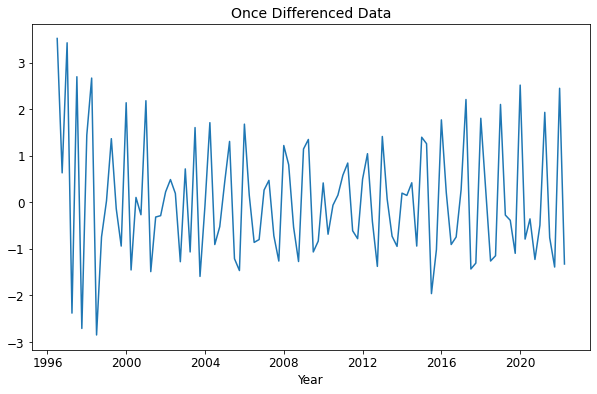

In [25]:
plot_series(ts_wind, ['first_diff'], title='Once Differenced Data', xlab='Year', steps=4)

In [26]:
# Checking for the stationarity of the once differenced data

adfuller(ts_wind['first_diff'])

(-3.463326877952313,
 0.00898042870479752,
 13,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 208.43142212205453)

Though the p-value is less than the alpha of 0.05, the test statistic is not smaller than the 1% critical value. I'll need to difference once more in order to make the data stationary.

#### 4.5.2. Twice Differenced

In [27]:
# Differencing the data

ts_wind['second_diff'] = ts_wind['avg_mag'].diff().diff()

In [28]:
# Dropping any null values as a result of the differencing

ts_wind.dropna(inplace=True)

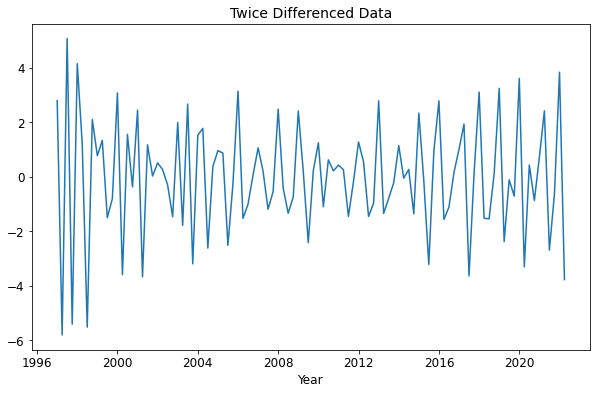

In [29]:
plot_series(ts_wind, ['second_diff'], title='Twice Differenced Data', xlab='Year', steps=4)

In [31]:
# Checking for the stationarity of the once differenced data

adfuller(ts_wind['second_diff'])

(-4.604089573793057,
 0.00012694619497675267,
 13,
 88,
 {'1%': -3.506944401824286,
  '5%': -2.894989819214876,
  '10%': -2.584614550619835},
 211.40470541736366)

The test statistic is now less than the critical values and the p-value is less than the alpha of 0.05. The data is now stationary and can be modeled on with ARIMA.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

Considering the few observations that I have to work with, I'll be using 90% of the data to train on.

In [32]:
y_train, y_test = train_test_split(ts_wind['second_diff'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

Because I needed to difference the data twice, I know that the d parameter for the ARIMA model is 2. Given that, I'll run a GridSearch for the most optimal p & q.

In [33]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 2, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},2,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},2,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,2,0) is: 586.8763551423119
The AIC for ARIMA(0,2,1) is: 490.340779600452


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,2,2) is: 402.1085283824165
The AIC for ARIMA(0,2,3) is: 328.2311296508499
The AIC for ARIMA(0,2,4) is: 292.88408808121545
The AIC for ARIMA(1,2,0) is: 523.1012729355743
The AIC for ARIMA(1,2,1) is: 445.6212113561634
The AIC for ARIMA(1,2,2) is: 377.0637410461466
The AIC for ARIMA(1,2,3) is: 320.7640907680871
The AIC for ARIMA(1,2,4) is: 329.9794628641604
The AIC for ARIMA(2,2,0) is: 492.83551680105177
The AIC for ARIMA(2,2,1) is: 420.93421845471323
The AIC for ARIMA(2,2,2) is: 353.80231613383853
The AIC for ARIMA(2,2,3) is: 299.7874779544152
The AIC for ARIMA(2,2,4) is: 286.784584788348
The AIC for ARIMA(3,2,0) is: 462.1407545729248
The AIC for ARIMA(3,2,1) is: 385.02294181943506
The AIC for ARIMA(3,2,2) is: 319.6716118860585
The AIC for ARIMA(3,2,3) is: 283.7468655624519
The AIC for ARIMA(3,2,4) is: 284.5087469155118
The AIC for ARIMA(4,2,0) is: 394.77416202824054


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(4,2,1) is: 330.08602014652035
The AIC for ARIMA(4,2,2) is: 288.33065678202564
The AIC for ARIMA(4,2,3) is: 283.0847035173409
The AIC for ARIMA(4,2,4) is: 281.5812737974828


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,2,4).
This model has an AIC of 281.5812737974828.


The p, d, q combination that returned the lowest AIC was when p=4, d=2, and q=4. This means that the model will perform best with the use of 4 lags, twice differenced data and a moving average window of 4. This combination, referred to as an order,  will be referenced as (4,2,4) and will be used as the ARIMA model order parameter.

### 5.3. Instantiate & Fit

In [34]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (4,2,4))

arima = model.fit()

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5.4. Test Forecast

In [35]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

11

In [36]:
# Generating the forecast for those 11 quarters

forecast = arima.forecast(steps=11)
forecast

2019-09-30   -0.126624
2019-12-31    0.872170
2020-03-31    0.248270
2020-06-30   -1.295589
2020-09-30    0.603341
2020-12-31    0.217348
2021-03-31    0.095126
2021-06-30   -0.386797
2021-09-30   -0.108223
2021-12-31    0.457523
2022-03-31   -0.124575
Freq: Q-DEC, Name: predicted_mean, dtype: float64

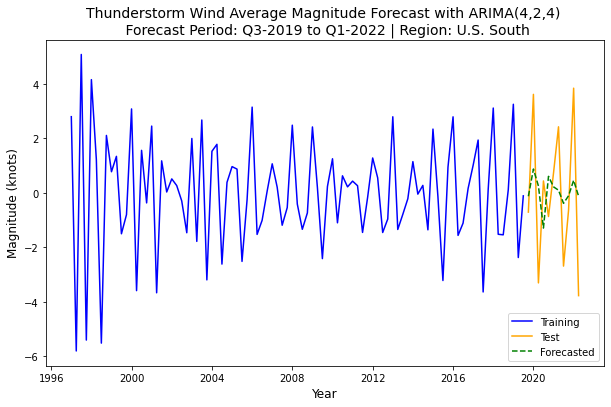

In [41]:
# Thunderstorm Wind Average Magnitude Forecast with ARIMA(4,2,4) - Forecast Period: Q3-2019 to Q1-2022 | Region: U.S. South

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Thunderstorm Wind Average Magnitude Forecast with ARIMA(4,2,4) \n Forecast Period: Q3-2019 to Q1-2022 | Region: U.S. South', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Magnitude (knots)', fontsize=12)

plt.legend();

Visually, the model does not seem to have forecasted very well. It did try to follow the fluctuations, but it stuck close to the mean in doing so.

### 5.5. Test Evaluation

In [42]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: 0.09811933324807287


The model does not do well in explaining the variability of the data , and is why the model stuck close to predicting the mean.

In [38]:
# Root mean squared error

rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 2.368713592785717


In [39]:
ts_wind.describe()

,avg_mag,first_diff,second_diff
count,102.000000,102.000000,102.000000
mean,53.676088,0.004333,-0.019200
std,1.142115,1.288991,2.122728
min,51.309100,-2.849375,-5.807328
25%,52.868367,-0.939561,-1.344808
50%,53.608344,-0.201252,0.119857
75%,54.488437,0.835151,1.243128
max,57.144670,3.427477,5.078301


The RMSE of 2.37 exceeded the standard deviation of 2.12. This model's forecasts are not reliable by these evaluation metric's standards.